## Import Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

## Data Preparation

In [2]:
# Define dataset directories
train_dir = "../Dataset for CA1 part A - AY2526S1/train"
val_dir = "../Dataset for CA1 part A - AY2526S1/validation"
test_dir = "../Dataset for CA1 part A - AY2526S1/test"

In [3]:
# Create a function to load the dataset, convert it to grayscale and resize it to the target size
def load_dataset(data_dir, target_size):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=(224, 224),  # Load original size first
        batch_size=32,
        label_mode="int",  # or 'categorical' if needed
        shuffle=True,
    )

    # Convert RGB to grayscale and resize to target size
    def preprocess(image, label):
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize(image, target_size)
        return image, label

    dataset = dataset.map(preprocess)
    return dataset

In [4]:
# Create datasets for both sizes
train_23 = load_dataset(train_dir, (23,23))
val_23 = load_dataset(val_dir, (23,23))
test_23 = load_dataset(test_dir, (23,23))

train_101 = load_dataset(train_dir, (101,101))
val_101 = load_dataset(val_dir, (101,101))
test_101 = load_dataset(test_dir, (101,101))

Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 7699 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.
Found 2200 files belonging to 11 classes.


In [5]:
# Verify one sample from each
def inspect_dataset(dataset, name):
    for images, labels in dataset.take(1):
        print(f"\n{name} - Batch info:")
        print("Image shape:", images.shape)
        print("Label shape:", labels.shape)
        print("Pixel range:", (images.numpy().min(), images.numpy().max()))
        if hasattr(dataset, 'class_names'):
            print("Classes:", dataset.class_names)
        else:
            print("Class names not available in dataset object")

inspect_dataset(train_23, "Train 23x23")
inspect_dataset(val_101, "Validation 101x101")


Train 23x23 - Batch info:
Image shape: (32, 23, 23, 1)
Label shape: (32,)
Pixel range: (0.0, 246.97137)
Class names not available in dataset object

Validation 101x101 - Batch info:
Image shape: (32, 101, 101, 1)
Label shape: (32,)
Pixel range: (0.0, 254.97452)
Class names not available in dataset object


23x23 Samples:


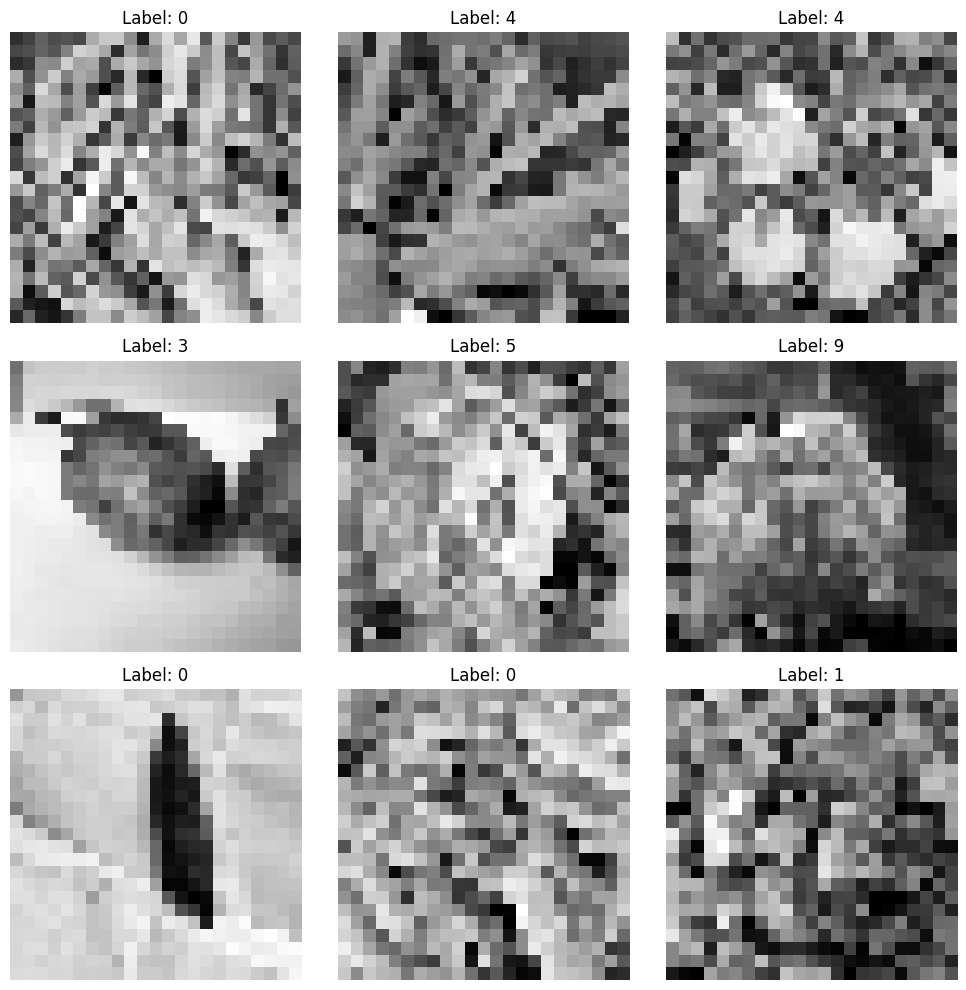


101x101 Samples:


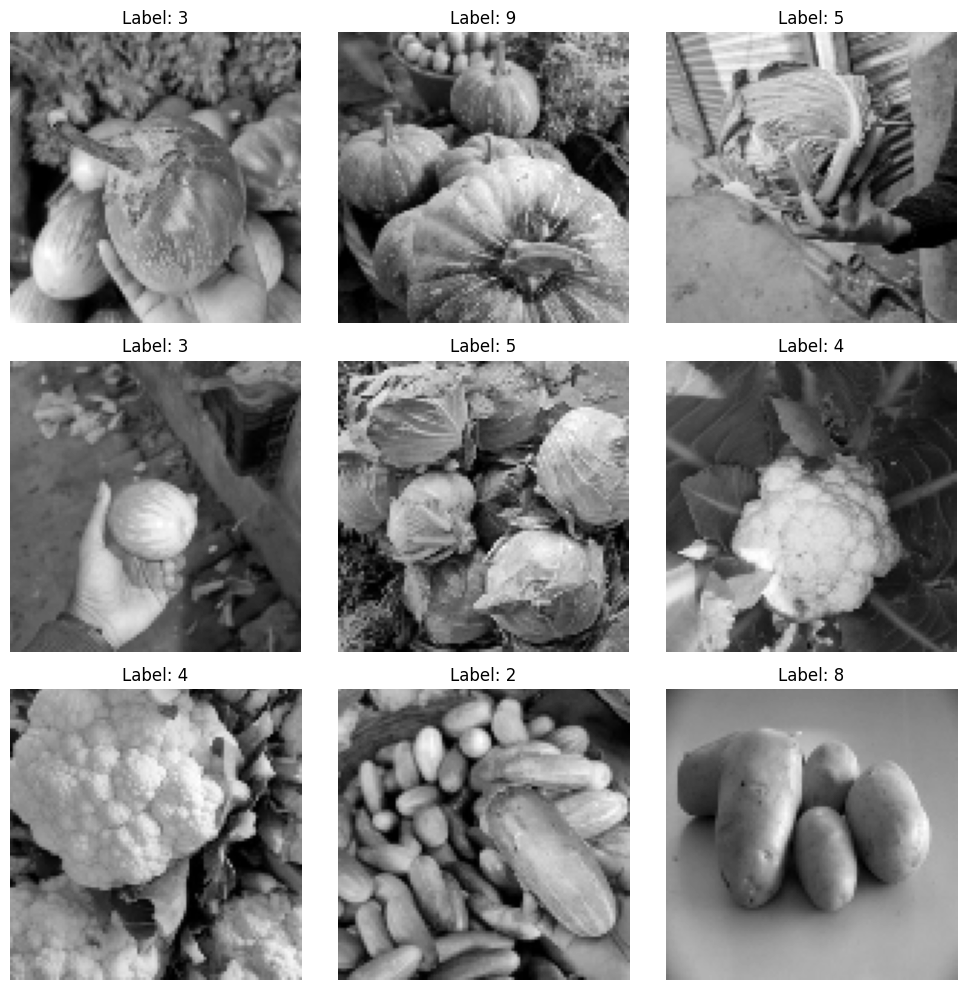

In [6]:
# View the first 9 samples of the training set
def show_samples(dataset, n=9):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(min(n, len(images))):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap="gray")
            plt.title(f"Label: {labels[i].numpy()}")
            plt.axis("off")
    plt.tight_layout()
    plt.show()


print("23x23 Samples:")
show_samples(train_23)

print("\n101x101 Samples:")
show_samples(train_101)

In [9]:
# Load just the class names without processing images
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=1,
    shuffle=False
)

print("\nClasses detected by TensorFlow:")
print(train_ds.class_names)

Found 7699 files belonging to 11 classes.

Classes detected by TensorFlow:
['Bean', 'Bitter_Gourd', 'Bottle_Gourd and Cucumber', 'Brinjal', 'Broccoli and Cauliflower', 'Cabbage', 'Capsicum', 'Carrot and Radish', 'Potato', 'Pumpkin', 'Tomato']


In [10]:
# Ensure preprocessing of the dataset was done correctly
def verify_preprocessing(dataset, expected_size):
    batch = next(iter(dataset.take(1)))
    images, _ = batch

    print("\nPreprocessing Verification:")
    print(f"Expected size: {expected_size}")
    print(f"Actual size: {images.shape[1:3]}")
    print(f"Channels: {images.shape[-1]} (1=grayscale)")
    print(f"Normalization check:")
    print(f"Min: {tf.reduce_min(images):.4f}, Max: {tf.reduce_max(images):.4f}")


verify_preprocessing(train_23, (23, 23))
verify_preprocessing(train_101, (101, 101))


Preprocessing Verification:
Expected size: (23, 23)
Actual size: (23, 23)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 251.2510

Preprocessing Verification:
Expected size: (101, 101)
Actual size: (101, 101)
Channels: 1 (1=grayscale)
Normalization check:
Min: 0.0000, Max: 254.9745


## Fully Connected Model (Baseline)


Training 23x23 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 10s 24ms/step - loss: 12.6743 - accuracy: 0.1181 - val_loss: 2.4036 - val_accuracy: 0.0909
Epoch 2/50
241/241 [==============================] - 7s 26ms/step - loss: 2.3709 - accuracy: 0.1183 - val_loss: 2.4125 - val_accuracy: 0.0905
Epoch 3/50
241/241 [==============================] - 7s 26ms/step - loss: 2.3599 - accuracy: 0.1159 - val_loss: 2.4222 - val_accuracy: 0.0900
Epoch 4/50
241/241 [==============================] - 8s 31ms/step - loss: 2.3547 - accuracy: 0.1173 - val_loss: 2.4306 - val_accuracy: 0.0900
Epoch 5/50
241/241 [==============================] - 7s 29ms/step - loss: 2.3515 - accuracy: 0.1185 - val_loss: 2.4372 - val_accuracy: 0.0900
Epoch 6/50
241/241 [==============================] - 7s 28ms/step - loss: 2.3508 - accuracy: 0.1186 - val_loss: 2.4422 - val_accuracy: 0.0909


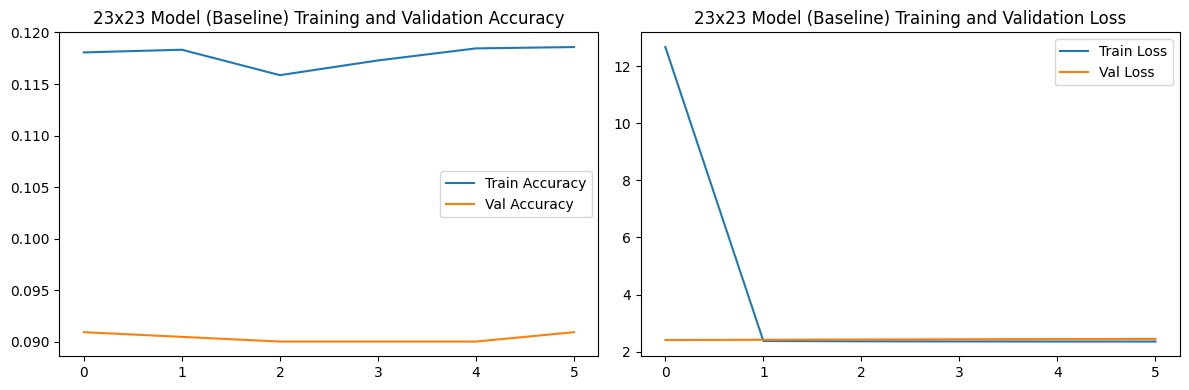

69/69 [==============================] - 2s 23ms/step - loss: 2.4416 - accuracy: 0.0909
23x23 Model (Baseline) - Test Accuracy: 0.0909
23x23 Model (Baseline) - Test Loss: 2.4416

Training 101x101 Model (Baseline)...
Epoch 1/50
241/241 [==============================] - 8s 29ms/step - loss: 38.4552 - accuracy: 0.1214 - val_loss: 2.4020 - val_accuracy: 0.0909
Epoch 2/50
241/241 [==============================] - 7s 29ms/step - loss: 2.3669 - accuracy: 0.1234 - val_loss: 2.4112 - val_accuracy: 0.0909
Epoch 3/50
241/241 [==============================] - 7s 28ms/step - loss: 2.3569 - accuracy: 0.1250 - val_loss: 2.4211 - val_accuracy: 0.0909
Epoch 4/50
241/241 [==============================] - 7s 29ms/step - loss: 2.3526 - accuracy: 0.1269 - val_loss: 2.4299 - val_accuracy: 0.0909
Epoch 5/50
241/241 [==============================] - 7s 29ms/step - loss: 2.3498 - accuracy: 0.1244 - val_loss: 2.4362 - val_accuracy: 0.0909
Epoch 6/50
241/241 [==============================] - 8s 30ms/step -

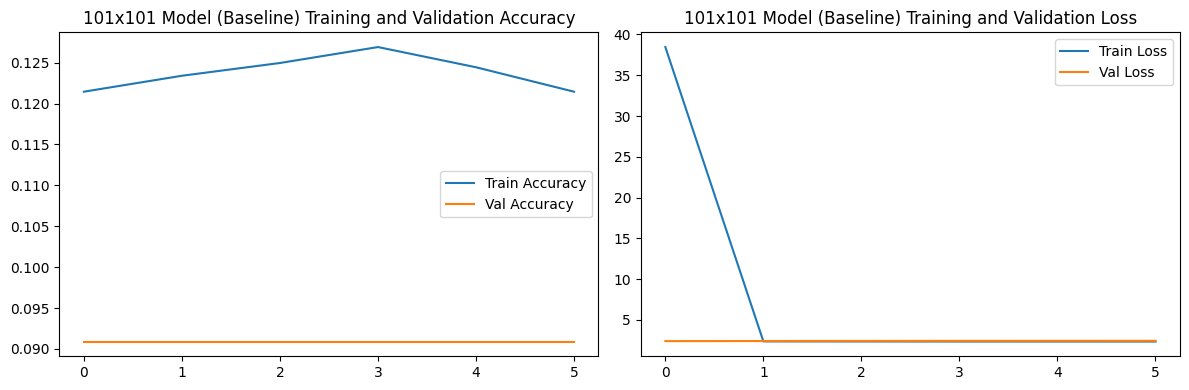

69/69 [==============================] - 2s 23ms/step - loss: 2.4409 - accuracy: 0.0909
101x101 Model (Baseline) - Test Accuracy: 0.0909
101x101 Model (Baseline) - Test Loss: 2.4409


In [11]:
# Function to create a simple fully connected model (baseline)
def create_fc_baseline_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),  # Flatten input to 1D
        layers.Dense(128, activation='relu'),     # Hidden layer with 128 neurons
        layers.Dropout(0.5),                      # Dropout layer to prevent overfitting
        layers.Dense(64, activation='relu'),      # Another hidden layer with 64 neurons
        layers.Dropout(0.5),                      # Dropout to prevent overfitting
        layers.Dense(num_classes, activation='softmax')  # Output layer with 'softmax' activation
    ])
    
    # Compile the model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Function to train the FC model and plot the training history
def train_fc_baseline_model(input_shape, num_classes, train_ds, val_ds, test_ds, model_name, epochs=50):
    # Create the model
    model = create_fc_baseline_model(input_shape, num_classes)
    
    # Train the model
    history = model.fit(
        train_ds,  # Training dataset
        validation_data=val_ds,  # Validation dataset
        epochs=epochs,  # Number of epochs
        callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],  # Early stopping to prevent overfitting
        verbose=1
    )
    
    # Plotting Training History
    plt.figure(figsize=(12, 4))
    
    # Plotting Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'{model_name} Training and Validation Accuracy')
    plt.legend()
    
    # Plotting Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{model_name} Training and Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Evaluate on the test dataset
    test_loss, test_acc = model.evaluate(test_ds)
    print(f"{model_name} - Test Accuracy: {test_acc:.4f}")
    print(f"{model_name} - Test Loss: {test_loss:.4f}")

    return model


# Example usage:

# 23x23 Model (Baseline)
print("\nTraining 23x23 Model (Baseline)...")
input_shape_23 = (23, 23, 1)  # For grayscale images of size 23x23 pixels
num_classes = 11  # 11 classes for classification (vegetables)
fc_baseline_model_23 = train_fc_baseline_model(input_shape_23, num_classes, train_23, val_23, test_23, "23x23 Model (Baseline)")

# 101x101 Model (Baseline)
print("\nTraining 101x101 Model (Baseline)...")
input_shape_101 = (101, 101, 1)  # For grayscale images of size 101x101 pixels
fc_baseline_model_101 = train_fc_baseline_model(input_shape_101, num_classes, train_101, val_101, test_101, "101x101 Model (Baseline)")


## Training CNN Models

In [12]:
# Create Function to Create the Model with the Following Layers by Passing in the Input Shape
def create_model(input_shape):
    model = models.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation="relu"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(128, (3, 3), activation="relu"),
            layers.Flatten(),
            layers.Dense(128, activation="relu"),
            layers.Dropout(0.5),
            layers.Dense(11, activation="softmax"),
        ]
    )

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [13]:
# Define Function to train the CNN Model
def train_model(model, train_ds, val_ds, model_name):
    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5)
    checkpoint = callbacks.ModelCheckpoint(
        f"best_{model_name}.h5", save_best_only=True, monitor="val_accuracy"
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=[early_stopping, checkpoint],
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training.png")
    plt.show()

    return model

Training 23x23 model...


Epoch 1/50
241/241 [==============================] - 18s 27ms/step - loss: 2.6579 - accuracy: 0.1555 - val_loss: 2.2089 - val_accuracy: 0.2395
Epoch 2/50
241/241 [==============================] - 7s 28ms/step - loss: 2.1181 - accuracy: 0.2544 - val_loss: 2.1003 - val_accuracy: 0.2695
Epoch 3/50
241/241 [==============================] - 7s 28ms/step - loss: 1.9213 - accuracy: 0.3442 - val_loss: 1.9444 - val_accuracy: 0.3373
Epoch 4/50
241/241 [==============================] - 7s 29ms/step - loss: 1.7192 - accuracy: 0.4206 - val_loss: 1.6126 - val_accuracy: 0.4445
Epoch 5/50
241/241 [==============================] - 7s 29ms/step - loss: 1.5335 - accuracy: 0.4820 - val_loss: 1.6735 - val_accuracy: 0.4355
Epoch 6/50
241/241 [==============================] - 7s 30ms/step - loss: 1.3878 - accuracy: 0.5277 - val_loss: 1.3857 - val_accuracy: 0.5432
Epoch 7/50
241/241 [==============================] - 7s 29ms/step - loss: 1.2319 - accuracy: 0.5796 - val_loss: 1.2692 - val_accuracy: 0.581

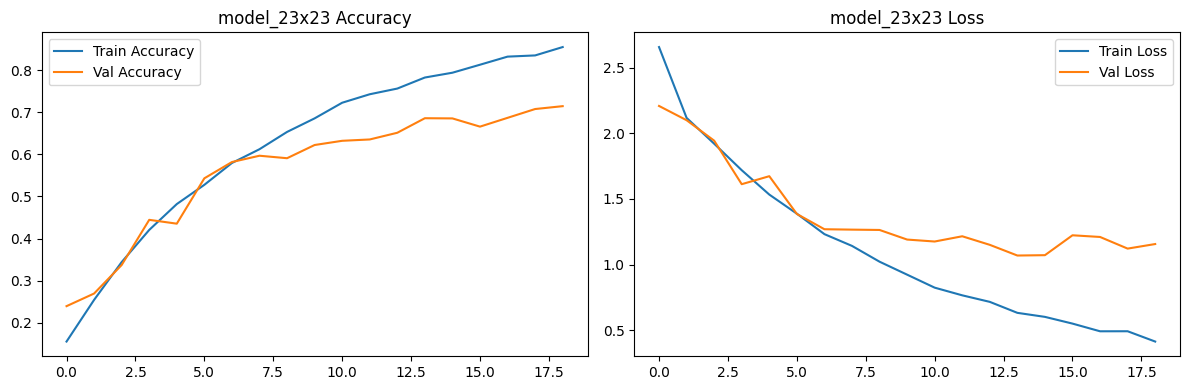


Training 101x101 model...
Epoch 1/50
241/241 [==============================] - 12s 40ms/step - loss: 3.9465 - accuracy: 0.2026 - val_loss: 2.1170 - val_accuracy: 0.2709
Epoch 2/50
241/241 [==============================] - 9s 36ms/step - loss: 2.0222 - accuracy: 0.3108 - val_loss: 2.0000 - val_accuracy: 0.3350
Epoch 3/50
241/241 [==============================] - 8s 34ms/step - loss: 1.7127 - accuracy: 0.4382 - val_loss: 1.9579 - val_accuracy: 0.3891
Epoch 4/50
241/241 [==============================] - 8s 33ms/step - loss: 1.3778 - accuracy: 0.5485 - val_loss: 1.8913 - val_accuracy: 0.4236
Epoch 5/50
241/241 [==============================] - 8s 33ms/step - loss: 1.1436 - accuracy: 0.6183 - val_loss: 1.9001 - val_accuracy: 0.4582
Epoch 6/50
241/241 [==============================] - 8s 34ms/step - loss: 0.9688 - accuracy: 0.6801 - val_loss: 1.9855 - val_accuracy: 0.4714
Epoch 7/50
241/241 [==============================] - 8s 33ms/step - loss: 0.8312 - accuracy: 0.7245 - val_loss: 1

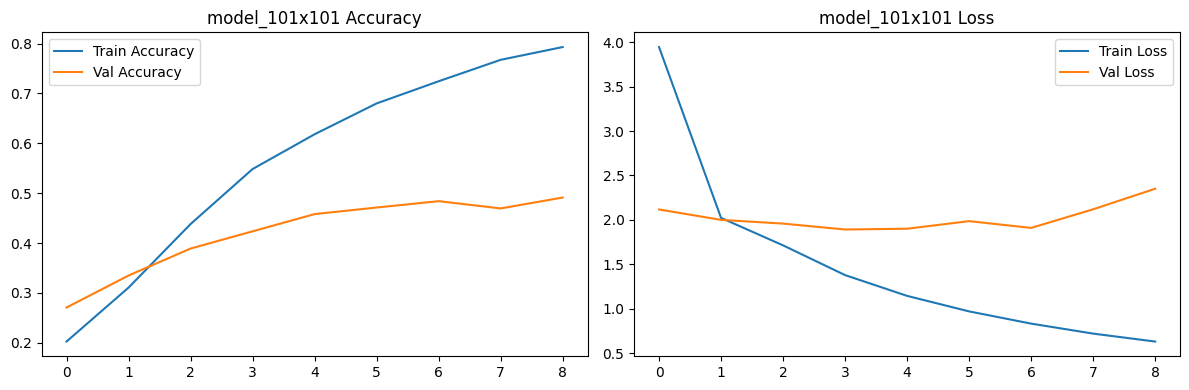

In [14]:
# Train the Models for the 2 different Input Sizes
print("Training 23x23 model...")
model_23 = create_model((23, 23, 1))
train_model(model_23, train_23, val_23, "model_23x23")

print("\nTraining 101x101 model...")
model_101 = create_model((101, 101, 1))
train_model(model_101, train_101, val_101, "model_101x101")

In [15]:
# Evaluate the model's Performance using the Test Dataset
# Evaluation with basic metrics
def evaluate_model_basic(model, test_ds, model_name):
    print(f"\nEvaluating {model_name}:")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1-accuracy):.4f}")
    return loss, accuracy


# Get metrics for comparison
loss_23, acc_23 = evaluate_model_basic(model_23, test_23, "23x23 Model")
loss_101, acc_101 = evaluate_model_basic(model_101, test_101, "101x101 Model")

print(f"\nAccuracy Improvement: {(acc_101-acc_23):.4f}")
print(f"Loss Reduction: {(loss_23-loss_101):.4f}")


Evaluating 23x23 Model:
Test Loss: 1.1106
Test Accuracy: 0.6991
Error Rate: 0.3009

Evaluating 101x101 Model:
Test Loss: 2.3276
Test Accuracy: 0.4823
Error Rate: 0.5177

Accuracy Improvement: -0.2168
Loss Reduction: -1.2170


## Improving the CNN Models

In [16]:
def create_improved_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(11, activation='softmax'),
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [ ]:
def train_improved_model(model, train_ds, val_ds, model_name, epochs=50):
    print(f"\nTraining {model_name} (Improved) model...")

    early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
    checkpoint = callbacks.ModelCheckpoint(
        f"best_{model_name}_improved.h5", save_best_only=True, monitor="val_accuracy"
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping, checkpoint],
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"], label="Train Accuracy")
    plt.plot(history.history["val_accuracy"], label="Val Accuracy")
    plt.title(f"{model_name} Accuracy (Improved)")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"{model_name} Loss (Improved)")
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{model_name}_training_improved.png")
    plt.show()

    return model



Training model_23x23 (Improved) model...
Epoch 1/50
241/241 [==============================] - 11s 38ms/step - loss: 1.8805 - accuracy: 0.3646 - val_loss: 1.6942 - val_accuracy: 0.4214
Epoch 2/50
241/241 [==============================] - 8s 32ms/step - loss: 1.3250 - accuracy: 0.5562 - val_loss: 1.2522 - val_accuracy: 0.5868
Epoch 3/50
241/241 [==============================] - 8s 33ms/step - loss: 1.0334 - accuracy: 0.6626 - val_loss: 1.0196 - val_accuracy: 0.6691
Epoch 4/50
241/241 [==============================] - 8s 33ms/step - loss: 0.8150 - accuracy: 0.7310 - val_loss: 0.9424 - val_accuracy: 0.7009
Epoch 5/50
241/241 [==============================] - 9s 36ms/step - loss: 0.6601 - accuracy: 0.7796 - val_loss: 2.7661 - val_accuracy: 0.4327
Epoch 6/50
241/241 [==============================] - 9s 34ms/step - loss: 0.5531 - accuracy: 0.8176 - val_loss: 1.1293 - val_accuracy: 0.6627
Epoch 7/50
241/241 [==============================] - 8s 34ms/step - loss: 0.4296 - accuracy: 0.859

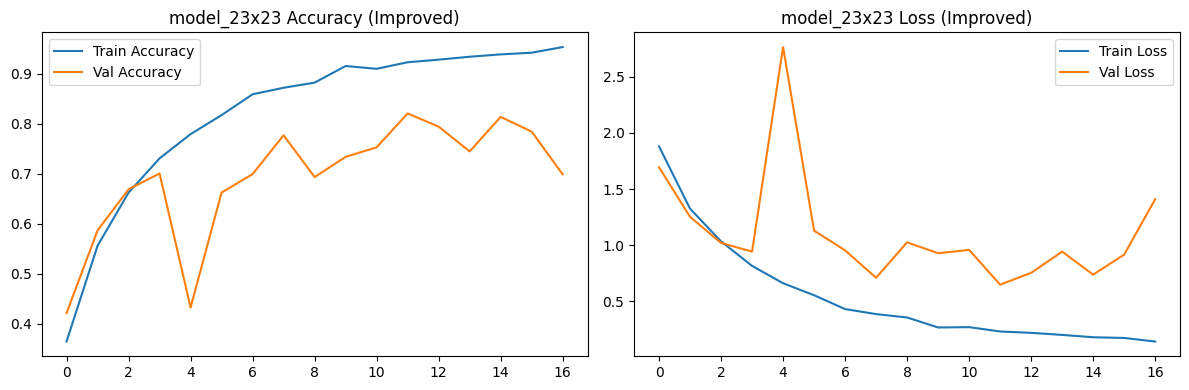


Training model_101x101 (Improved) model...
Epoch 1/50
241/241 [==============================] - 12s 41ms/step - loss: 1.5501 - accuracy: 0.4717 - val_loss: 2.6488 - val_accuracy: 0.2845
Epoch 2/50
241/241 [==============================] - 9s 38ms/step - loss: 1.0106 - accuracy: 0.6670 - val_loss: 2.9298 - val_accuracy: 0.3959
Epoch 3/50
241/241 [==============================] - 9s 38ms/step - loss: 0.7094 - accuracy: 0.7748 - val_loss: 2.5165 - val_accuracy: 0.4886
Epoch 4/50
241/241 [==============================] - 9s 38ms/step - loss: 0.5710 - accuracy: 0.8192 - val_loss: 0.9952 - val_accuracy: 0.6814
Epoch 5/50
241/241 [==============================] - 9s 38ms/step - loss: 0.4464 - accuracy: 0.8570 - val_loss: 2.3527 - val_accuracy: 0.5405
Epoch 6/50
241/241 [==============================] - 9s 37ms/step - loss: 0.3745 - accuracy: 0.8804 - val_loss: 1.7228 - val_accuracy: 0.5850
Epoch 7/50
241/241 [==============================] - 9s 37ms/step - loss: 0.3193 - accuracy: 0.9

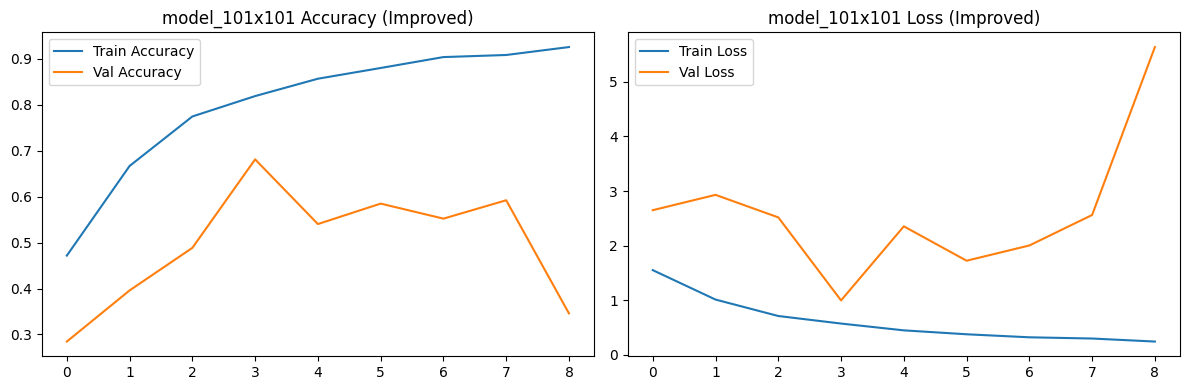

In [18]:
# Create improved models
improved_model_23 = create_improved_model((23, 23, 1))
improved_model_101 = create_improved_model((101, 101, 1))

# Train improved models
improved_model_23 = train_improved_model(improved_model_23, train_23, val_23, "model_23x23")
improved_model_101 = train_improved_model(improved_model_101, train_101, val_101, "model_101x101")


In [19]:
# Evaluate the improved model's performance using the test dataset
def evaluate_model_basic_improved(model, test_ds, model_name):
    print(f"\nEvaluating {model_name} (Improved):")
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1 - accuracy):.4f}")
    return loss, accuracy


# Evaluate improved models
loss_23_improved, acc_23_improved = evaluate_model_basic_improved(improved_model_23, test_23, "23x23 Model")
loss_101_improved, acc_101_improved = evaluate_model_basic_improved(improved_model_101, test_101, "101x101 Model")

# Comparison between improved models
print(f"\nAccuracy Improvement (101x101 - 23x23): {(acc_101_improved - acc_23_improved):.4f}")
print(f"Loss Reduction (23x23 - 101x101): {(loss_23_improved - loss_101_improved):.4f}")



Evaluating 23x23 Model (Improved):
Test Loss: 0.6797
Test Accuracy: 0.8036
Error Rate: 0.1964

Evaluating 101x101 Model (Improved):
Test Loss: 1.0317
Test Accuracy: 0.6668
Error Rate: 0.3332

Accuracy Improvement (101x101 - 23x23): -0.1368
Loss Reduction (23x23 - 101x101): -0.3520


## Further improvement of the models

In [25]:
def create_enhanced_23_model(input_shape=(23, 23, 1)):
    model = tf.keras.Sequential([
        # Enhanced Feature Extraction
        layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),
        
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.35),
        
        # Spatial Attention
        layers.Conv2D(1, (1,1), activation='sigmoid'),
        layers.Multiply(),
        
        # Classifier
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(11, activation='softmax')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [26]:
def create_enhanced_101_model(input_shape=(101, 101, 1)):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Stem Network
    x = layers.Conv2D(32, (7,7), strides=2, activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((3,3), strides=2)(x)
    
    # Inception-like Blocks
    branch1 = layers.Conv2D(64, (1,1), activation='relu')(x)
    
    branch2 = layers.Conv2D(64, (1,1), activation='relu')(x)
    branch2 = layers.Conv2D(64, (3,3), padding='same', activation='relu')(branch2)
    
    branch3 = layers.Conv2D(64, (1,1), activation='relu')(x)
    branch3 = layers.Conv2D(64, (5,5), padding='same', activation='relu')(branch3)
    
    x = layers.concatenate([branch1, branch2, branch3])
    x = layers.MaxPooling2D((3,3))(x)
    x = layers.Dropout(0.4)(x)
    
    # Feature Refinement
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    
    # Classifier with Regularization
    x = layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.6)(x)
    outputs = layers.Dense(11, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [27]:
def train_enhanced_model(model, train_ds, val_ds, model_name, epochs=100):
    print(f"\nTraining Enhanced {model_name} model...")
    
    callbacks_list = [
        callbacks.EarlyStopping(patience=8, restore_best_weights=True),
        callbacks.ModelCheckpoint(
            f"best_enhanced_{model_name}.h5",
            save_best_only=True,
            monitor='val_accuracy'
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1
        )
    ]
    
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=callbacks_list,
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title(f'Enhanced {model_name} Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'Enhanced {model_name} Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'enhanced_{model_name}_training.png')
    plt.show()
    
    return model

In [34]:
import seaborn as sns

def evaluate_enhanced_model(model, test_ds, model_name):
    print(f"\nEvaluating Enhanced {model_name}:")
    model.load_weights(f"best_enhanced_{model_name}.h5")  # Load best weights
    
    # Basic evaluation
    loss, accuracy = model.evaluate(test_ds, verbose=0)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Error Rate: {(1-accuracy):.4f}")
    
    # Confusion matrix
    y_true = []
    y_pred = []
    for images, labels in test_ds.unbatch():
        y_true.append(labels.numpy())
        pred = model.predict(images[None,...], verbose=0)
        y_pred.append(np.argmax(pred))
    
    cm = tf.math.confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=test_ds.class_names,
                yticklabels=test_ds.class_names)
    plt.title(f'Enhanced {model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(f'enhanced_{model_name}_confusion.png')
    plt.show()
    
    return loss, accuracy

# 4. Main Training Pipeline
# Create enhanced models
enhanced_model_23 = create_enhanced_23_model()
enhanced_model_101 = create_enhanced_101_model()

# Train enhanced models
enhanced_model_23 = train_enhanced_model(enhanced_model_23, train_23, val_23, "23x23")
enhanced_model_101 = train_enhanced_model(enhanced_model_101, train_101, val_101, "101x101")

# Evaluate enhanced models
loss_23_enhanced, acc_23_enhanced = evaluate_enhanced_model(enhanced_model_23, test_23, "23x23")
loss_101_enhanced, acc_101_enhanced = evaluate_enhanced_model(enhanced_model_101, test_101, "101x101")

# Comparison
print("\nEnhanced Models Comparison:")
print(f"23x23 Accuracy: {acc_23_enhanced:.2%}")
print(f"101x101 Accuracy: {acc_101_enhanced:.2%}")
print(f"Accuracy Difference: {(acc_101_enhanced-acc_23_enhanced):.4f}")
print(f"Loss Difference: {(loss_23_enhanced-loss_101_enhanced):.4f}")

ValueError: A merge layer should be called on a list of inputs. Received: input_shape=(None, 5, 5, 1) (not a list of shapes)

## Implement Hyperparameter Tuning for the 23x23 Model

In [28]:
import keras_tuner as kt

# Define the model-building function for Keras Tuner
def build_model_with_hyperparameters(hp):
    model = models.Sequential()
    
    # Conv Layer 1
    model.add(layers.Conv2D(
        hp.Int('conv_1_filters', min_value=32, max_value=128, step=32),
        (3, 3), activation='relu', input_shape=(23, 23, 1)
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 2
    model.add(layers.Conv2D(
        hp.Int('conv_2_filters', min_value=64, max_value=256, step=64),
        (3, 3), activation='relu'
    ))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Layer 3
    model.add(layers.Conv2D(
        hp.Int('conv_3_filters', min_value=128, max_value=512, step=128),
        (3, 3), activation='relu'
    ))
    model.add(layers.BatchNormalization())
    
    model.add(layers.GlobalAveragePooling2D())
    
    # Dense Layer
    model.add(layers.Dense(
        hp.Int('dense_units', min_value=64, max_value=512, step=64),
        activation='relu'
    ))
    model.add(layers.Dropout(hp.Float('dropout_rate', min_value=0.3, max_value=0.6, step=0.1)))
    
    # Output Layer
    model.add(layers.Dense(11, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='LOG')),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Set up Keras Tuner with Random Search
tuner = kt.RandomSearch(
    build_model_with_hyperparameters,
    objective='val_accuracy',
    max_trials=30,
    directory='kt_dir',
    project_name='improved_model_tuning'
)



Reloading Tuner from kt_dir\improved_model_tuning\tuner0.json


In [29]:
# Run hyperparameter tuning
tuner.search(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)]
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps.values}")


Best Hyperparameters: {'conv_1_filters': 96, 'conv_2_filters': 256, 'conv_3_filters': 512, 'dense_units': 128, 'dropout_rate': 0.3, 'learning_rate': 7.285461811915875e-05}


In [30]:
# Build and train the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    train_23,  # Training dataset
    validation_data=val_23,  # Validation dataset
    epochs=50,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)],
    verbose=1
)


Epoch 1/50
241/241 [==============================] - 11s 39ms/step - loss: 1.8050 - accuracy: 0.4030 - val_loss: 1.7513 - val_accuracy: 0.4168
Epoch 2/50
241/241 [==============================] - 9s 37ms/step - loss: 1.2149 - accuracy: 0.6070 - val_loss: 1.1679 - val_accuracy: 0.6259
Epoch 3/50
241/241 [==============================] - 11s 43ms/step - loss: 0.9176 - accuracy: 0.7202 - val_loss: 0.9696 - val_accuracy: 0.6977
Epoch 4/50
241/241 [==============================] - 10s 39ms/step - loss: 0.7296 - accuracy: 0.7870 - val_loss: 0.8311 - val_accuracy: 0.7491
Epoch 5/50
241/241 [==============================] - 11s 43ms/step - loss: 0.5625 - accuracy: 0.8452 - val_loss: 0.7689 - val_accuracy: 0.7627
Epoch 6/50
241/241 [==============================] - 10s 41ms/step - loss: 0.4430 - accuracy: 0.8883 - val_loss: 0.6897 - val_accuracy: 0.7900
Epoch 7/50
241/241 [==============================] - 9s 37ms/step - loss: 0.3390 - accuracy: 0.9210 - val_loss: 0.6578 - val_accuracy: 0

In [31]:
# Evaluate the best model
test_loss, test_acc = best_model.evaluate(test_23)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


69/69 [==============================] - 2s 25ms/step - loss: 0.6423 - accuracy: 0.8105
Test Accuracy: 0.8105
Test Loss: 0.6423


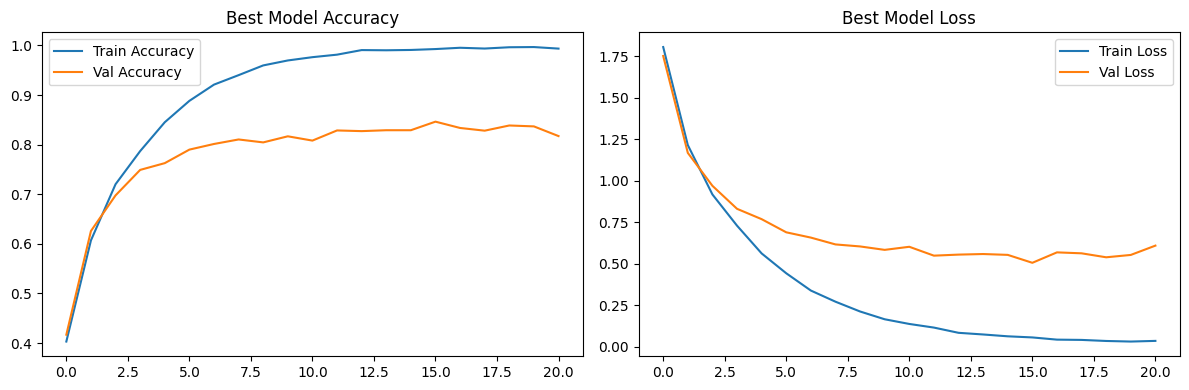

In [32]:
# Plotting Accuracy and Loss
plt.figure(figsize=(12, 4))

# Plotting Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title(f"Best Model Accuracy")
plt.legend()

# Plotting Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title(f"Best Model Loss")
plt.legend()

plt.tight_layout()
plt.show()


## Implement Hyperparameter Tuning for the 101x101 Model